In [27]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import os
from torch import nn
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import seaborn as sns
from ray import tune

In [28]:
# # old preprocessing steps

# # loop through all files in "data/good_data" and concatenta them into one dataframe
# df = pd.concat([pd.read_csv(f"data/good_data/{file}") for file in os.listdir("data/good_data")])
# # keep only common_name, condition, latitude_coordinate, longitude_coordinate, and native columns
# df = df[['common_name', 'condition', 'latitude_coordinate', 'longitude_coordinate', 'native']]
# # convert condition to numerical
# df['condition'] = df['condition'].replace({'excellent': 4, 'good': 3, 'fair': 2, 'poor': 1, 'dead/dying': 0, 'dead': 0})
# # one hot "common_name" column
# df = pd.get_dummies(df, columns=["common_name"])
# # one hot native column
# df = pd.get_dummies(df, columns=["native"])
# # drop native_no_info column
# df.drop(columns=['native_no_info'], inplace=True)
# # drop rows where condition is null
# df = df.dropna(subset=['condition'])

Raytune?

In [29]:
# import data from processed_data.csv for full set of small_set_processed_data.csv for3 city sample
# df = pd.read_csv('small_set_processed_data.csv')
df = pd.read_csv('processed_data.csv')

# split into X and y
X = df.drop('condition', axis=1)
y = df['condition']

# convert from boolean to int
y = y.astype(int)
X = X.astype(float)

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# convert to torch tensors
X_train = torch.tensor(X_train.values)
X_test = torch.tensor(X_test.values)
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

In [30]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [31]:
# parameters
input_size = len(X.columns)
num_classes = len(df['condition'].unique())
num_epochs = 100

In [32]:
hidden_size = 300
num_epochs = 100
batch_size = 100
learning_rate = 0.0001

# create model
model = NeuralNet(input_size, hidden_size, num_classes)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Training model for learning rate 0.001


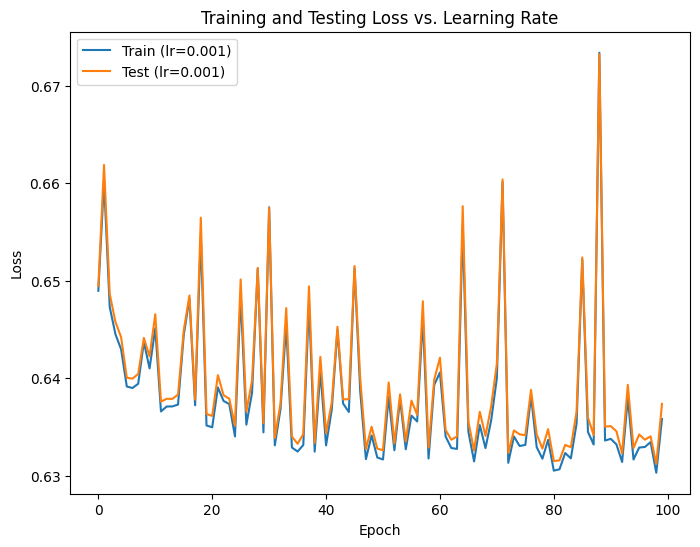

In [33]:
def train_model(model, optimizer, criterion, X_train, y_train, batch_size):
    train_losses = []
    test_losses = []
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X.float())
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        # calculate train loss
        train_outputs = model(X_train.float())
        train_loss = criterion(train_outputs, y_train)
        train_losses.append(train_loss.item())
        # calculate test loss
        test_outputs = model(X_test.float())
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())
    return train_losses, test_losses

learning_rates = [0.001]
train_losses = []
test_losses = []

for lr in learning_rates:
    print(f"Training model for learning rate {lr}")
    # create model
    model = NeuralNet(input_size, hidden_size, num_classes)
    # loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # train model
    train_loss, test_loss = train_model(model, optimizer, criterion, X_train, y_train, batch_size)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# generate plot
plt.figure(figsize=(8,6))
for i, lr in enumerate(learning_rates):
    plt.plot(train_losses[i], label=f"Train (lr={lr})")
    plt.plot(test_losses[i], label=f"Test (lr={lr})")
plt.title("Training and Testing Loss vs. Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [34]:
# return accuracy of model
def get_accuracy(model, X, y):
    outputs = model(X.float())
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y).sum().item()
    total = y.size(0)
    return correct / total

# get accuracy of model
print(f"Accuracy of model: {get_accuracy(model, X_test, y_test)}")

Accuracy of model: 0.7716370869649949
